<a href="https://colab.research.google.com/github/AlexCergeev/Analog-of-AlphaZero/blob/main/%D0%9A%D1%83%D1%80%D1%81%D0%B0%D1%87.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Start on GPU (Runtime shape High-RAM)**

# Import required libraries

You need to upload 3 files: 

1.   data.pgn
2.   stockfish.csv
3.   stockfish_13_linux_x64_bmi2.zim



In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
!pip install python-chess==0.31.3

     |████████████████████████████████| 143kB 6.5MB/s 
  Found existing installation: python-chess 0.23.11
    Uninstalling python-chess-0.23.11:
      Successfully uninstalled python-chess-0.23.11


In [3]:
!unzip /content/stockfish_13_linux_x64_bmi2.zip
!chmod +x /content/stockfish_13_linux_x64_bmi2/stockfish_13_linux_x64_bmi2

unzip:  cannot find or open /content/stockfish_13_linux_x64_bmi2.zip, /content/stockfish_13_linux_x64_bmi2.zip.zip or /content/stockfish_13_linux_x64_bmi2.zip.ZIP.
chmod: cannot access '/content/stockfish_13_linux_x64_bmi2/stockfish_13_linux_x64_bmi2': No such file or directory


In [3]:
!unzip /content/drive/MyDrive/Chess/chessData.csv.zip

Archive:  /content/drive/MyDrive/Chess/chessData.csv.zip
  inflating: chessData.csv           


In [4]:
import chess
import chess.engine
import chess.pgn
import random
from PIL import Image, ImageFilter
import numpy as np
import requests
from io import BytesIO
import matplotlib.pyplot as plt
from scipy import signal
import tensorflow as tf
import time
import csv

In [5]:
import tensorflow.keras.models as models
import tensorflow.keras.layers as layers
import tensorflow.keras.utils as utils
import tensorflow.keras.optimizers as optimizers
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Conv2D, \
                                    Dense, \
                                    MaxPool2D,\
                                    Dropout, \
                                    Flatten, \
                                    BatchNormalization,\
                                    Input
import tensorflow.keras.callbacks as callbacks

In [6]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Activation
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import categorical_crossentropy
from tensorflow.keras.utils import to_categorical
import sys

# GPU Optimization

In [7]:
gpus = tf.config.experimental.list_physical_devices('GPU')
if gpus:
  try:
    # Currently, memory growth needs to be the same across GPUs
    for gpu in gpus:
      tf.config.experimental.set_memory_growth(gpu, True)
    logical_gpus = tf.config.experimental.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Memory growth must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


# Functions

In [8]:
# this function will create our f(x) (score)
def stockfish(board):
  with chess.engine.SimpleEngine.popen_uci('/content/stockfish_13_linux_x64_bmi2/stockfish_13_linux_x64_bmi2') as sf:
    for i in range(19, 0, -1):    
      result = sf.analyse(board, chess.engine.Limit(depth=i))
      score = result['score'].white().score()
      if score is not None: break
    return score

In [11]:
board = chess.Board()

In [7]:
BOARD_SIZE = (8, 8, 6)
PIECE_TO_INDEX = {'P' : 0, 'R' : 1, 'N' : 2, 'B' : 3, 'Q' : 4, 'K' : 5}
INDEX_TO_PIECE = {0 : 'P', 1 : 'R', 2 : 'N', 3 : 'B', 4 : 'Q', 5 : 'K'}
Y_TO_CHESSY = {0 : 'a', 1 : 'b', 2 : 'c', 3 : 'd', 4 : 'e', 5 : 'f', 6 : 'g', 7 : 'h'}
CHESSY_TO_Y = {'a' : 0, 'b' : 1, 'c' : 2, 'd' : 3, 'e' : 4, 'f' : 5, 'g' : 6, 'h' : 7}

In [8]:
def convert_bitboard_to_image(board):
	im2d = np.array(list(board.split()[0].replace('/', '').replace('8', '.'*8).replace('7', '.'*7).replace('6', '.'*6).replace('5', '.'*5).replace('4', '.'*4).replace('3', '.'*3).replace('2', '.'*2).replace('1', '.'*1))).reshape((8, 8))
	im = np.array(np.random.rand(8,8,6)/10, dtype=np.float16) #np.zeros(BOARD_SIZE, dtype=np.int8)

	for i in range(BOARD_SIZE[0]):
		for j in range(BOARD_SIZE[1]):
			piece = im2d[i, j]
			if piece == '.': continue
			if piece.isupper():
				im[i, j, PIECE_TO_INDEX[piece.upper()]] = 1
			else:
				im[i, j, PIECE_TO_INDEX[piece.upper()]] = -1
  

	return im

In [15]:
def board_to_image(board):
	im2d = np.array(list(str(board).replace('\n', '').replace(' ', ''))).reshape((8, 8))
	im = np.zeros(BOARD_SIZE)

	for i in range(BOARD_SIZE[0]):
		for j in range(BOARD_SIZE[1]):
			piece = im2d[i, j]
			if piece == '.': continue
			if piece.isupper():
				im[i, j, PIECE_TO_INDEX[piece.upper()]] = 1
			else:
				im[i, j, PIECE_TO_INDEX[piece.upper()]] = -1

	return im

In [16]:
def predict(board):
  board3d = board_to_image(board)
  board3d = np.expand_dims(board3d, 0)
  return model.predict(board3d)[0][0]

**The AI will learn how to give a accurate prediction of *f(x)* when we present a *x* never seen before.**

*board -> score*

# Creating the dataset

In [9]:
y_train = []
x_train = []

with open('/content/chessData.csv', newline='') as File:  
    reader = csv.reader(File)
    for step, row in enumerate(reader):
        if row == ['FEN', 'Evaluation']:
          continue 
        fen, stfish = row[0], row[1]

        x_train.append(convert_bitboard_to_image(fen))

        if stfish[0]=='#':
          if stfish[1] =='-':
            stfish = "-15312"
          if stfish[1] =='+':
            stfish = "+15312"
        
        y_train.append(float(stfish.replace("\ufeff", ""))/100)

        if step % 2000000 == 0:  print("step =",step)
        #if step > 4000000: break

x_train = np.array(x_train)
y_train = np.array(y_train)

mean = np.mean(y_train)
std = np.std(y_train)
y_train = np.asarray((y_train-mean)/ std, dtype=np.float32)

#y_train = np.asarray(y_train / abs(y_train).max() / 2 + 0.5, dtype=np.float32)
print(x_train.shape)
print(y_train.shape)

step = 2000000
step = 4000000
step = 6000000
step = 8000000
step = 10000000
step = 12000000
(12958035, 8, 8, 6)
(12958035,)


In [10]:
#mean = np.mean(y_train)
#std = np.std(y_train)
# y_train = np.asarray((y_train-mean)/ std, dtype=np.float32)
np.std(y_train)

1.0000001

In [37]:
Y_TRAIN = y_train

Now we need to convert the board representation to something meaningful.

A 3d matrix of sizes **8 x 8 x 6**



Now, all we have to do is call **random_board()** to create random boards, **stockfish()** to get a score for how good each board is for white.

Then we convert each board to a 3d matrix using **split_dims()**, now creating the dataset is easy!

# TensorFlow!

Skip connections (residual network) will likely improve the model for deeper connections. If you want to test the residual model, check the code below.

In [25]:
def build_model_residual(conv_size, conv_depth):
  board3d = layers.Input(shape=(8, 8, 6))

  # adding the convolutional layers
  x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', data_format='channels_first')(board3d)
  for _ in range(conv_depth):
    previous = x
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', data_format='channels_first')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation(tf.keras.layers.LeakyReLU())(x)
    x = layers.Conv2D(filters=conv_size, kernel_size=3, padding='same', data_format='channels_first')(x)
    x = layers.BatchNormalization()(x)
    x = layers.Add()([x, previous])
    x = layers.Activation(tf.keras.layers.LeakyReLU())(x)
  x = layers.Flatten()(x)
  #x = layers.Dense(64, activation=tf.keras.layers.LeakyReLU())(x)
  #x = layers.Dropout(0.3)(x)
  #x = layers.Dense(512, 'relu')(x)
  #x = layers.Dropout(0.3)(x)
  x = layers.Dense(4, 'relu')(x)
  x = layers.Dropout(0.1)(x)
  x = layers.Dense(1, 'sigmoid')(x)

  return models.Model(inputs=board3d, outputs=x)
model_residual = build_model_residual(8,2)
model_residual.summary()

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_7 (InputLayer)            [(None, 8, 8, 6)]    0                                            
__________________________________________________________________________________________________
conv2d_30 (Conv2D)              (None, 8, 8, 6)      584         input_7[0][0]                    
__________________________________________________________________________________________________
conv2d_31 (Conv2D)              (None, 8, 8, 6)      584         conv2d_30[0][0]                  
__________________________________________________________________________________________________
batch_normalization_24 (BatchNo (None, 8, 8, 6)      24          conv2d_31[0][0]                  
____________________________________________________________________________________________

# It's training time!

https://www.tensorflow.org/api_docs/python/tf/keras/activations

In [11]:
def build_model(conv_depth):
  board3d = layers.Input(shape=(8, 8,6))

  # adding the convolutional layers
  x = board3d
  x = layers.Conv2D(conv_depth, kernel_size=(3,3), padding='same', activation="softsign")(x)
  x = layers.Flatten()(x)
  x = layers.Dense(16, activation="selu")(x)
  x = layers.Dropout(0.1)(x)
  #x = layers.Dense(2,activation="relu")(x) #, kernel_regularizer=tf.keras.regularizers.L1(0.01), activity_regularizer=tf.keras.regularizers.L2(0.01)
  #x = layers.Dropout(0.2)(x)
  x = layers.Dense(16, activation=tf.keras.layers.LeakyReLU())(x) #kernel_regularizer=tf.keras.regularizers.L1(0.01),
  x = layers.Dropout(0.05)(x)
  x = layers.Dense(1, activation="softsign")(x)
  return models.Model(inputs=board3d, outputs=x)

  
model = build_model(6)
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 8, 8, 6)]         0         
_________________________________________________________________
conv2d (Conv2D)              (None, 8, 8, 6)           330       
_________________________________________________________________
flatten (Flatten)            (None, 384)               0         
_________________________________________________________________
dense (Dense)                (None, 16)                6160      
_________________________________________________________________
dropout (Dropout)            (None, 16)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_1 (Dropout)          (None, 16)                0     

In [ ]:
model = build_model(6)
#model = build_model_residual(8,2)
model.compile(optimizer=optimizers.Adam(), loss='mean_squared_error')
model.summary()
model.fit(x_train, y_train,   # TODO x_train, y_train change to ai traing 
            batch_size=512,
            epochs=30,
            verbose=1,
            validation_split=0.1)#,
            #callbacks=[callbacks.ReduceLROnPlateau(monitor='loss', patience=10),
             #         callbacks.EarlyStopping(monitor='loss', patience=15)])

Model: "model_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_7 (InputLayer)         [(None, 8, 8, 6)]         0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 8, 8, 6)           330       
_________________________________________________________________
flatten_6 (Flatten)          (None, 384)               0         
_________________________________________________________________
dense_18 (Dense)             (None, 16)                6160      
_________________________________________________________________
dropout_12 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_19 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_13 (Dropout)         (None, 16)                0   

In [12]:
samples = step - 20000
# Instantiate an optimizer.
optimizer = optimizers.Adam()
# Instantiate a loss function.

loss_fn = tf.compat.v1.losses.mean_squared_error

# Prepare the training dataset.
batch_size = 64


# Reserve 10,000 samples for validation.
x_val = x_train[samples:]
y_val = y_train[samples:]
x_train_final = x_train[:samples]
y_train_final = y_train[:samples]

# Prepare the training dataset.
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_final, y_train_final))
#train_dataset = train_dataset.shuffle(buffer_size=1024).batch(batch_size)

# Prepare the validation dataset.
val_dataset = tf.data.Dataset.from_tensor_slices((x_val, y_val))
val_dataset = val_dataset.batch(batch_size)

In [ ]:
EPOCHS = 5
#model = build_model_residual(8,4)
model = build_model(6)
BS = 1000
numUpdates = int(y_train.shape[0] / BS)
history_grad = []
sum_history = []

for epoch in range(0, EPOCHS):
    print("\nStart of epoch %d" % (epoch,))
    for i in range(0, numUpdates):
              with tf.GradientTape() as tape:
                start = i * BS
                end = start + BS
                logits = model(x_train_final[start:end], training=True)  # Logits for this minibatch
                
                # Compute the loss value for this minibatch.
                loss_value = tf.keras.losses.MSE(y_train_final[start:end], logits)

                # Use the gradient tape to automatically retrieve
                # the gradients of the trainable variables with respect to the loss.
                grads = tape.gradient(loss_value, model.trainable_weights)

                # Run one step of gradient descent by updating
                # the value of the variables to minimize the loss.
                optimizer.apply_gradients(zip(grads, model.trainable_weights))
                #sum_history.append(np.average(grads))
                for layers_grads in grads:
                  sum_history.append(np.average(layers_grads))
                history_grad.append(sum_history)
                if start > samples:
                  break

                # Log every 200 batches.
                #if i % 400 == 0:
                    #print("Training loss (for one batch) at step %d: %.4f"% (start, float(loss_value)))
                    #print("Seen so far: %s samples" % ((start + 1) * batch_size))




Start of epoch 0

Start of epoch 1

Start of epoch 2

Start of epoch 3

Start of epoch 4


In [ ]:
b=0
for st, i in enumerate(grads):
  #print(i.shape)
  b = st+1
  #if  st > 100:break
#print(b)

layer_all = []
num = b
for i in range(0,b):
  layer = []
  for s, layers_grads in enumerate(history_grad[0]):
    if ((s+1)%num == i):
      layer.append(layers_grads)
    #print("layer",(s+1)%num,',', layers_grads)
    #if s > 1000: break

  layer_all.append(layer)

In [ ]:
for i in layer_all:
  plt.plot(i)
  plt.xlabel("layer")
  plt.xlabel("butch")
  plt.grid()
  plt.show()
 

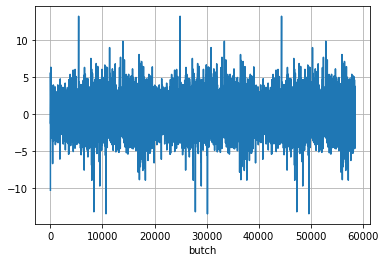

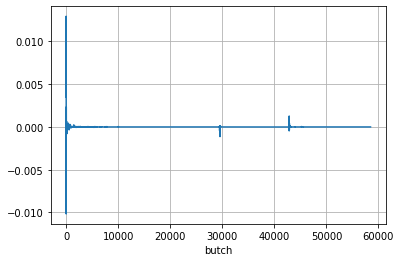

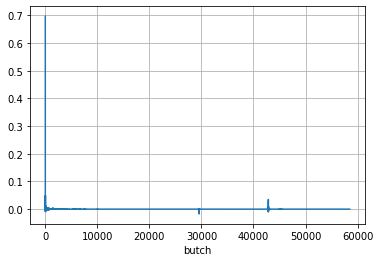

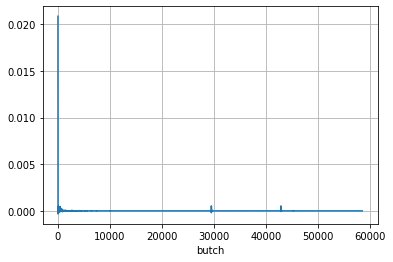

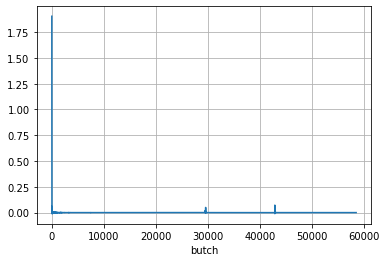

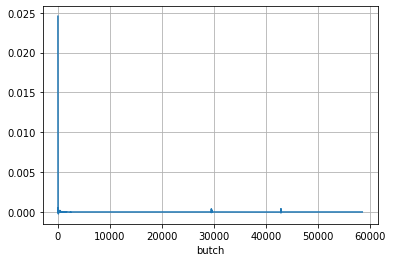

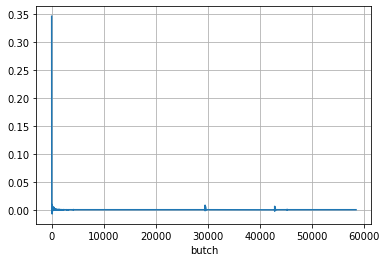

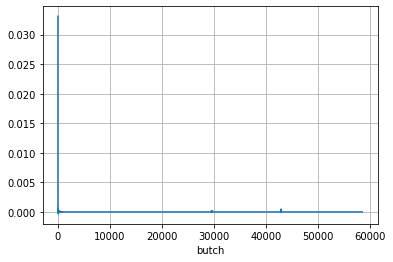

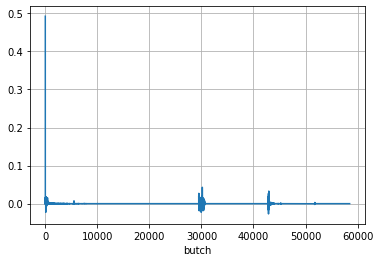

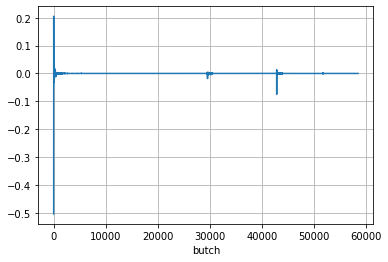

In [22]:
for i in layer_all:
  plt.plot(i)
  plt.xlabel("layer")
  plt.xlabel("butch")
  plt.grid()
  plt.show() 

(0.0, 29.0)

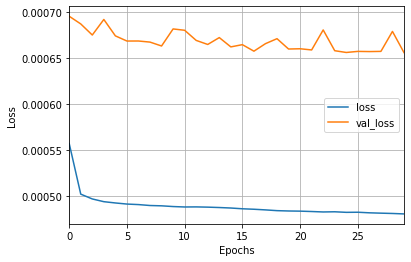

In [13]:
i = 0 #len(All_history)-1
plt.xlabel('Epochs')
plt.ylabel("Loss")
plt.plot(All_history[i].epoch, All_history[i].history["loss"],  label='loss')
plt.grid()
plt.plot(All_history[i].epoch, All_history[i].history["val_loss"],  label='val_loss' )
plt.legend()
plt.xlim([0, max(All_history[i].epoch)])


# Playing with the AI

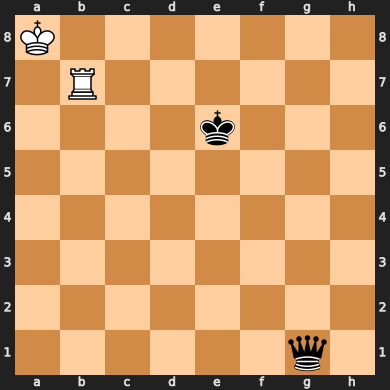

In [20]:
chess.Board("K7/1R6/4k3/8/8/8/8/6q1 b - - 3 64")

In [ ]:
with chess.engine.SimpleEngine.popen_uci('stockfish-5-linux/Linux/stockfish_14053109_x64') as engine:
  while True:
    h = []
    move_answer = []
    depth = 19
    start = stockfish(board, depth)
    d = depth
    while(start is None):
      d = d - 1
      start = stockfish(board, d)
      
    for move in board.legal_moves:
      board.push(move)
      start_next = stockfish(board, depth)
      d = depth
      while (start_next is None):
        d = d - 1
        start_next = stockfish(board, d)      
      h.append(start - start_next)
      move_answer.append(move)
      board.pop()     
    board.push(move_answer[h.index(min(h))])
    print(f'\n{board}')
    if board.is_game_over():
      break

    move = engine.analyse(board, chess.engine.Limit(time=0.1), info=chess.engine.INFO_PV)['pv'][0]
    board.push(move)
    print(f'\n{board}')
    if board.is_game_over():
      break

In [174]:
def get_move(board):
  h = []
  move_answer = []
  start = predict(board)
  for move in board.legal_moves:
      board.push(move)
      h.append(abs(start - predict(board)))
      move_answer.append(move)
      #print(move,abs(start - predict(board)))
      board.pop()
  #print(move_answer[h.index(min(h))])
  #print(move_answer[h.index(max(h))])
  return move_answer[h.index(max(h))]

In [89]:
start_fish = (stockfish(board)+50)/100
h = []
move_answer = []
for move in board.legal_moves:
    board.push(move)
    h.append(start_fish - (stockfish(board)+50)/100)
    move_answer.append(move)
    #print(move,abs(start_fish - (stockfish(board)+50)/100))
    board.pop()
print(move_answer[h.index(min(h))])

d2d4


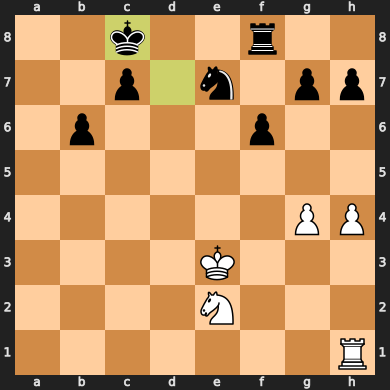

In [178]:
board.push(get_move(board))
# get_move(board)
board

In [ ]:
board.push_uci('d7d5')

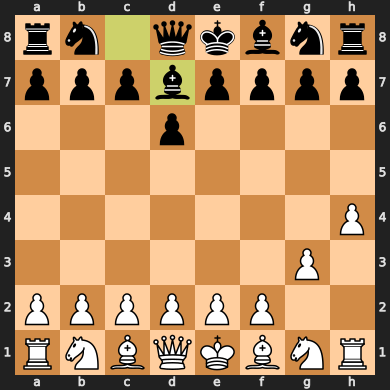

In [107]:
board

In [80]:
board.pop()

Move.from_uci('g2g4')

In [98]:
get_move(board)

Move.from_uci('g2g3')